# Bayesian Structural Time Series

## The model

<font size="3"> Let $\pmb{y} = (y_1, \ldots, y_n)$ denote the time series of interest. In general, a structural time series models is comprised of two equations, an *observation equation* and a *transition equation*. It is the assumption of the model that $y_t$ is influenced by a vector of unobserved latent state variables, denoted as $\alpha_t$. Explicity, the relation between $y_t$ and $\alpha_t$ is described by <font>

<font size="3"> \begin{align}&y_t = Z_t \alpha_t + \varepsilon_t, \qquad &\varepsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2) \tag{1}\\ &\alpha_{t+1} = T_t \alpha_{t} + R_{t} \eta_{t}, \qquad &\eta_{t} \sim \mathcal{N}(0, Q_{t}), \tag{2}\end{align} <font>

<font size="3"> where (1) is the *observation equation* and (2) is the *transition equation*. For our purposes, we will use the specific structural time series model <font>

<font size="3"> \begin{align*} &y_t = \mu_t + \tau_t + X_t\beta + \varepsilon_t, \qquad &&\varepsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2) \\ &\mu_t = \mu_{t-1} + \delta_{t-1} + u_t, \qquad &&u_t \sim \mathcal{N}(0, \sigma_{u}^2)\\ &\delta_t = \delta_{t-1} + v_t, \qquad &&v_t \sim \mathcal{N}(0, \sigma_{v}^2) \\ &\tau_t = - \sum_{s = 1}^{S-1} \tau_{t-s} + w_t, \qquad &&w_t \sim \mathcal{N}(0, \sigma_{w}^2)\end{align*} <font>

<font size="3">where we assume that $\varepsilon_t$, $u_t$, $v_t$ and $w_t$ are independent centered Gaussian random variables with constant variances. Additionaly, we also assume that the regression coefficients remain constant throughout time. The parameters that are to be learnt in this model are the variances of the noise components  $\sigma_{\epsilon}^2, \sigma_u^2, \sigma_v^2, \sigma_w^2$, and the regression coefficients, $\beta \in \mathbb{R}^d$. We concisely denote these parameters as $\phi = (\sigma_{\epsilon}^2, \sigma_u^2, \sigma_v^2, \sigma_w^2, \beta)$. <font>

<font size="3"> While there are several different ways of learning these parameters, TensorFlow Probability provides two primary methods for learning the posterior distribution $p(\phi|\pmb{y})$, variational inference and Hamiltonian Monte Carlo. We decided on using variational inference.

<font size="3"> In variational inference, we place some prior distribution on the parameters of interest, $p(\phi)$, and we choose a family of surrogate posteriors $q_{\theta}(\phi)$ over the parameters parameterized by a parameter $\theta$ to approximate the true posterior $p(\phi | \pmb{y})$. In the case of TensorFlow's implementation of structural time series models, it places by default a log normal prior based on the underlying observed time series on $\sigma_{\varepsilon}, \sigma_u, \sigma_v$ and $\sigma_w$. For the regression weights, TensorFlow either places a Student's t prior on them if one uses `tfp.sts.LinearRegression`, or a socalled Horseshoe prior if one uses `tfp.sts.SparseLinearRegression` instead. For more details, we refer readers to the TensorFlow documentation. We then search for<font>

<font size="3">\begin{align*}q_{\theta^*} &= \operatorname{arg min}_{\theta \in \Theta} \operatorname{KL}(q_{\theta} \Vert p) \\ &= \operatorname{arg min}_{\theta \in \Theta} \mathbb{E}_{Z \sim q_{\theta}}\left[ \log \left( \frac{q_{\theta}(Z)}{p(Z \vert \pmb{y})}\right) \right]\end{align*}<font>

<font size="3">Using Bayes' theorem, we then get<font>

<font size="3"> \begin{align*}\mathbb{E}_{Z \sim q_{\theta}}\left[ \log \left( \frac{q_{\theta}(Z)}{p(Z \vert \pmb{y})}\right) \right] &= \mathbb{E}_{Z \sim q_{\theta}}\left[ \log \left( \frac{q_{\theta}(Z)p(\pmb{y})}{p(Z, \pmb{y})}\right) \right]
\\&= \mathbb{E}_{Z \sim q_{\theta}}\left[ \log \left( \frac{q_{\theta}(Z)}{p(Z, \pmb{y})}\right) +  \log\left( p(\pmb{y})\right) \right] 
\\ &= \mathbb{E}_{Z \sim q_{\theta}}\Big[\log \big( q_{\theta}(Z) \big) - \log \big(p(Z, \pmb{y})\big)\Big] + \mathbb{E}_{Z \sim q_{\theta}}\Big[\log\big(p(\pmb{y})\big) \Big]
\\ & = -\mathbb{E}_{Z \sim q_{\theta}}\Big[\log \big(p(Z, \pmb{y})\big) - \log \big( q_{\theta}(Z) \big) \Big] + \log \big( p(\pmb{y})\big).\end{align*}<font>

<font size="3">Therefore, we conclude that minimizing $\operatorname{KL}(q_{\theta} \Vert p)$ is equivalent to minimizing $-\mathbb{E}_{Z \sim q_{\theta}}\Big[\log \big(p(Z, \pmb{y})\big) - \log \big( q_{\theta}(Z)\big) \Big]$, since $\log\big(p(\pmb{y})\big)$ is a constant and independent of $\theta$. The term $-\mathbb{E}_{Z \sim q_{\theta}}\Big[\log \big(p(Z, \pmb{y})\big) - \log \big( q_{\theta}(Z)\big) \Big]$ is know as the so called negative ELBO. <font>

<font size="3">The function `tfp.vi.fit_surrogate_posterior` minimizes the empirically computed negative ELBO loss between $q_{\theta}(\phi)$ and the unnormalized joint distribution $p(\phi, \pmb{y})$ for $N$ samples from the surrogate posterior. That is to say that for $N$ samples from the surrogate posterior, TensorFlow minimizes \begin{equation*}- \frac{1}{N} \sum_{i=1}^N \big(log(p(\phi_i,\pmb{y})) - log(q_{\theta}(\phi_i))\big), \quad \phi_i \sim q_{\theta} \text{ for } i = 1, \ldots, N\end{equation*}<font>


<font size="3"> which is computable, because both the joint distribution and the surrogate posterior are. <font>

<font size="3">After approximating the true posterior $p(\phi \vert \pmb{y})$ with our trained surrogate posterior $q^*_{\theta}(\phi)$, we can then perform forecasts by sampling from said fitted surrogate posterior. For $N$ samples of our model parameters from $q^*_{\theta}(\phi)$, we can approximate both the mean and standard deviations via their empircal counterparts.<font>

<font size="3">We denote our $N$ parameter samples from our fitted surrogate posterior as $\phi_1, \ldots, \phi_N$. Then, for each of these smaples, the Kalman filter is used to compute the latent state distribution at time $n$ conditioned on $\pmb{y}$ and the current sampled parameter values. The Kalman filter then returns the distribution $p(\alpha_n | \pmb{y})$ which for a state space model with Gaussian noise is also Gaussian. <font>

<font size="3">In general, structural time series model assume that the time series of interest may take on any value in $\mathbb{R}$, which is a problem in our case since we are modeling volatility. For this reason, we decided to model the log-volatility instead. After fitting the model in TensorFlows, the function `tfp.sts.forecast` returns the predictive distribution over future observations for a given horizon.<font>

<font size="3">Since we are only interested in one-step-ahead forecasts, we get from `tfp.sts.forecast` the distribution $p(y_{n+1} \vert \pmb{y})$ with mean $\mu_{n+1}$ and standard deviation $\sigma_{n+1}$. The mean of this distribution we then use as our one-point forecast for the next log-volatiliy. In order to now get get a predicted value for the volatility at time $n+1$, we compute $\exp\left(\mu_{n+1} + \frac{\sigma_{n+1}^2}{2} \right)$ which we use as our one-point forecast of the volatility at time point $n+1$.<font>

In [189]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.preprocessing import StandardScaler

In [3]:
sts = tfp.sts
mcmc = tfp.mcmc
tfd = tfp.distributions
tfb = tfp.bijectors
vi = tfp.vi

In [4]:
df = pd.read_csv("btc/data_df.csv")

# Apply the logarithm transformation to all the values in the column 'vol'
df["vol"] = np.log(df["vol"])

# Rename the column 'vol' to 'log(vol)'
df.rename(columns={"vol": "log(vol)"}, inplace=True)

# Drop the return columns
cols_to_drop = ["ret"] + [f"ret_t-{i}" for i in range(1, 13)]

order_book_look_back = 10
df.drop(columns=cols_to_drop, inplace=True)
df.drop(columns=df.columns[2 + order_book_look_back * 10 :], inplace=True)

In [6]:
def add_log_vol_lags(
    df: pd.DataFrame, log_vol_col: str, vol_look_back: int, drop_na: bool = False
) -> pd.DataFrame:
    """
    Adds lagged versions of an existing log-vol column, inserting them
    just to the right of log_vol_col.

    Parameters
    ----------
    df            : pd.DataFrame
        Your data, which already contains a log-volatility column.
    log_vol_col   : str
        Name of the log-vol column (e.g. 'log_vol').
    vol_look_back : int
        Number of lagged columns to add.
    drop_na       : bool, default False
        If True, drop any rows with NaN in the new lag columns.

    Returns
    -------
    pd.DataFrame
        A copy of df with new columns:
        - '{log_vol_col}_t-1', …, '{log_vol_col}_t-{vol_look_back}'
        inserted right after the original log_vol_col.
    """
    df2 = df.copy()
    # Generate names of the lag columns
    lag_cols = [f"{log_vol_col}_t-{i}" for i in range(1, vol_look_back + 1)]
    # Create the lagged columns (they’ll temporarily go to the end)
    for i, col in enumerate(lag_cols, start=1):
        df2[col] = df2[log_vol_col].shift(i)

    # Reorder: insert lag_cols after log_vol_col
    cols = list(df2.columns)
    try:
        idx = cols.index(log_vol_col)
    except ValueError:
        raise KeyError(f"Column '{log_vol_col}' not found in DataFrame.")

    # Build new column order
    before = cols[: idx + 1]  # everything up to and including log_vol_col
    after = [c for c in cols if c not in before + lag_cols]
    new_order = before + lag_cols + after
    df2 = df2[new_order]

    # Optionally drop any rows with missing lags
    if drop_na:
        df2 = df2.dropna(subset=lag_cols).reset_index(drop=True)

    return df2

In [7]:
vol_look_back = 10

lagged_df = add_log_vol_lags(
    df=df, log_vol_col="log(vol)", vol_look_back=vol_look_back, drop_na=True
)

In [8]:
def make_weekly_walk_forward_splits(
    df: pd.DataFrame,
    date_col: str,
    initial_training_set_end: str,
    target_col: str = "log_vol",
) -> tuple[list[list[np.ndarray]], list[list[np.ndarray]]]:
    """
    Assumes df is sorted ascending by date_col and contains a column `target_col`.

    Returns two equally‐long lists:
      - training_sets[i] = [y_train_i, X_train_i]
      -  test_sets[i] = [y_test_i,  X_test_i]

    where each test window is one calendar‐week ahead (to the next Monday),
    and each train window drops the prior week's rows and appends the prior test.

    Parameters
    ----------
    df : pd.DataFrame
        Hourly data, sorted by date_col.
    date_col : str
        Name of the datetime column (“YYYY-MM-DD HH:MM:SS”).
    initial_training_set_end : str
        Cutoff for first train, e.g. "2018-07-01 23:00:00".
    target_col : str, default 'log_vol'
        Name of the target column to predict.

    Returns
    -------
    training_sets : list of [y_train, X_train]
    test_sets     : list of [y_test,  X_test]
    """
    # 1) Copy & parse
    df2 = df.copy()
    df2[date_col] = pd.to_datetime(df2[date_col])

    # helper to find first timestamp ≥ next Monday after ts
    def next_monday(ts: pd.Timestamp) -> pd.Timestamp | None:
        days_ahead = (7 - ts.weekday()) % 7 or 7
        target = (ts + pd.Timedelta(days=days_ahead)).normalize()
        mask = df2[date_col] >= target
        return df2.loc[mask, date_col].iloc[0] if mask.any() else None

    # 2) Initial train/test split
    cutoff = pd.to_datetime(initial_training_set_end)
    train_df = df2[df2[date_col] <= cutoff]
    if train_df.empty:
        raise ValueError("No rows on or before initial_training_set_end")

    first_monday = next_monday(cutoff)
    if first_monday is None:
        return [], []

    test_df = df2[(df2[date_col] > cutoff) & (df2[date_col] <= first_monday)]
    if test_df.empty:
        return [], []

    # extract y/X and drop datetime & target from X
    def to_pair(split_df: pd.DataFrame) -> list[np.ndarray]:
        y = split_df[target_col].to_numpy()
        X = split_df.drop(columns=[date_col, target_col]).to_numpy()
        return [y, X]

    training_sets = [to_pair(train_df)]
    test_sets = [to_pair(test_df)]
    last_test_end = test_df[date_col].max()

    # 3) Walk‐forward
    while True:
        nm = next_monday(last_test_end)
        if nm is None:
            break

        next_test_df = df2[(df2[date_col] > last_test_end) & (df2[date_col] <= nm)]
        if next_test_df.empty:
            break

        # build next train by dropping last 7*24 rows of current train and appending current test
        y_prev, X_prev = training_sets[-1]
        y_test_prev, X_test_prev = test_sets[-1]

        if y_prev.shape[0] < 7 * 24:
            break

        y_next = np.concatenate([y_prev[: -7 * 24], y_test_prev])
        X_next = np.vstack([X_prev[: -7 * 24], X_test_prev])

        training_sets.append([y_next, X_next])
        test_sets.append(to_pair(next_test_df))

        last_test_end = next_test_df[date_col].max()

    return training_sets, test_sets

In [9]:
train_end_data = "2018-07-03 23:00:00"

In [10]:
training_sets, test_sets = make_weekly_walk_forward_splits(
    df=lagged_df,
    date_col="datetime",
    initial_training_set_end=train_end_data,
    target_col="log(vol)",
)

In [11]:
print(len(training_sets))
print(len(test_sets))

12
12


In [152]:
import time


class sts_model:
    def __init__(
        self,
        y_train,
        X_train=None,
        level=True,
        trend=False,
        season=False,
        seasonal_period=0,
        learning_rate=1e-4,
        sparse=True,
    ):
        y = np.asarray(y_train, dtype=np.float32)
        self.y_mean = y.mean()
        self.y_std = y.std() if y.std() != 0 else 1.0
        y_std = (y - self.y_mean) / self.y_std
        self.y_train = tf.convert_to_tensor(y_std, dtype=tf.float32)

        if X_train is not None:
            X = np.asarray(X_train, dtype=np.float32)
            self.X_mean = X.mean(axis=0)
            self.X_std = X.std(axis=0)
            self.X_std[self.X_std == 0] = 1.0
            X_std = (X - self.X_mean) / self.X_std
            self.X_train = tf.convert_to_tensor(X_std, dtype=tf.float32)
        else:
            self.X_train = None
            self.X_mean = None
            self.X_std = None

        self.level = level
        self.trend = trend
        self.season = season
        self.seasonal_period = seasonal_period
        self.lr = learning_rate
        self.sparse = sparse
        self.components, self.model = self.build_model(
            self.y_train,
            self.X_train,
            self.level,
            self.trend,
            self.season,
            self.seasonal_period,
            self.sparse,
        )

        # We now build a surrogate posterior that factors over the model parameters
        self.surrogate_posterior = sts.build_factored_surrogate_posterior(self.model)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Helper function that builds a tfp.sts model. Returns both the model components and the built model itself
    def build_model(
        self,
        y_train,
        X_train=None,
        level=True,
        trend=False,
        season=False,
        seasonal_period=0,
        sparse=True,
    ):
        components = []
        if level == True and trend == False:
            level_component = sts.LocalLevel(observed_time_series=y_train, name="level")
            components.append(level_component)
        if level == True and trend == True:
            local_linear_trend_component = sts.LocalLinearTrend(
                observed_time_series=y_train, name="trend"
            )
            components.append(local_linear_trend_component)
        if season == True:
            season_component = sts.Seasonal(
                num_seasons=seasonal_period,
                observed_time_series=y_train,
                name="seasonality",
            )
            components.append(season_component)
        if X_train is not None:
            if sparse == True:
                order_book_feat = sts.SparseLinearRegression(
                    design_matrix=X_train, name="order_book_features"
                )
            else:
                order_book_feat = sts.LinearRegression(
                    design_matrix=X_train, name="order_book_features"
                )
            components.append(order_book_feat)

        model = sts.Sum(
            components=components, observed_time_series=y_train, name="sts_model"
        )
        return components, model

    # This function takes an univariate time series dataset y and fits our structural time series to the given data y
    # via variational inference. By defautl, we use a learning rate of 1e-3 and 1e5 iterations. The function returns
    # the ELBO loss recorded during training and returns it.
    @tf.function(reduce_retracing=True)
    def train(self, num_steps=int(1e5)):
        self.optimizer.learning_rate = self.lr
        elbo_loss_history = tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=self.model.joint_distribution(
                observed_time_series=self.y_train
            ).log_prob,
            surrogate_posterior=self.surrogate_posterior,
            optimizer=self.optimizer,
            num_steps=num_steps,
            jit_compile=True,
        )
        return elbo_loss_history

    # This function returns a predictive distribution over future observations for of length horizon. First, we sample
    # the parameters of our model posterior_samples-times from the fitted surrogate posterior. Then we use the function
    # tfp.sts.forecast to produce predictive distribution over future observations for of length horizon.
    def one_step_forecast_dist(self, posterior_samples=int(1e3)):
        model_q_samples = self.surrogate_posterior.sample(posterior_samples)
        forecast_dist = tfp.sts.forecast(
            self.model,
            observed_time_series=self.y_train,
            parameter_samples=model_q_samples,
            num_steps_forecast=1,
        )
        return forecast_dist

    # Builds a new tfp.sts model with the newly observed feature variables X_new and updates both self.components and
    # self.model

    def update_design_matrix(self, X_new):
        # 1) turn X_new into a (1, K) array and standardize it
        x = np.asarray(X_new, dtype=np.float32)
        x_std = (x - self.X_mean) / self.X_std
        x_t = tf.convert_to_tensor(x_std)
        if x_t.ndim == 1:
            x_t = tf.expand_dims(x_t, axis=0)

        # 2) append only the standardized row
        self.X_train = tf.concat([self.X_train, x_t], axis=0)

        # 3) rebuild the model structure
        self.components, self.model = self.build_model(
            self.y_train,
            self.X_train,
            self.level,
            self.trend,
            self.season,
            self.seasonal_period,
            self.sparse,
        )

    # Rebuilds the tfp.sts model with the newly observed target variable y_new and updates both self.components and
    # self.model
    def update_observed_time_series(self, y_new):
        #!!! Double check the standardizing
        y = np.asarray(y_new, dtype=np.float32)
        y_std = (y - self.y_mean) / self.y_std
        y_t = tf.convert_to_tensor([y_std], dtype=tf.float32)
        self.y_train = tf.concat([self.y_train, y_t], axis=0)

        # y_new = tf.convert_to_tensor([y_new], dtype=tf.float32)
        # observed_time_series_new = tf.concat([self.y_train, y_new], axis=0)
        # self.y_train = observed_time_series_new
        self.components, self.model = self.build_model(
            y_train=self.y_train,
            X_train=self.X_train,
            level=self.level,
            trend=self.trend,
            season=self.season,
            seasonal_period=self.seasonal_period,
            sparse=self.sparse,
        )

    # Iterates over the y_test. It first observes the first row in X_test, updates self.X_train by appending said row
    # to self.X_train. It then computes both the predictive mean and standard deviation of first element in y_test based
    # on the learnt parameters and the given design matrix and appends both as a dictionary to the list preds. It then
    # continues this process to it has produced predicitons for all entrys in y_test. If print_ is set to True, then
    # the function prints out updates.
    def interval_one_step_pred(self, y_test, X_test=None, print_=False):
        preds = []
        if X_test is None:
            for i, y_next in enumerate(y_test):
                if print_ == True:
                    start = time.time()
                dist = self.one_step_forecast_dist()
                m_std = dist.mean().numpy()[0, 0]
                s_std = dist.stddev().numpy()[0, 0]

                # back to original scale
                m = m_std * self.y_std + self.y_mean
                s = s_std * self.y_std
                preds.append({"y_pred_mean": m, "y_pred_std": s})

                # observe the true y and update
                self.update_observed_time_series(y_next)

                if print_ and (i % max(1, len(y_test) // 20) == 0):
                    print(f"Step {i + 1} took {time.time() - start:.2f}s")
            return preds

        for i, (x_next, y_next) in enumerate(zip(X_test, y_test)):
            if print_ == True:
                start = time.time()

            self.update_design_matrix(x_next[None, :])
            dist = self.one_step_forecast_dist()

            m_std = dist.mean().numpy()[0, 0]
            s_std = dist.stddev().numpy()[0, 0]
            m = m_std * self.y_std + self.y_mean
            s = s_std * self.y_std
            preds.append({"y_pred_mean": m, "y_pred_std": s})

            self.update_observed_time_series(y_next)

            if print_ and (i % max(1, len(y_test) // 20) == 0):
                print(f"Step {i + 1} took {time.time() - start:.2f}s")

        return preds

    def print_estimated_parameter_means(self, sample_num=int(1e3)):
        # Draw samples from the trained VI posterior:
        q_samples = self.surrogate_posterior.sample(sample_num)

        # 3. For each named parameter, compute & print the mean:
        for param in self.model.parameters:
            draws = q_samples[param.name].numpy()  # shape [200, …]
            print(f"{param.name:25s}  mean = {np.mean(draws, axis=0)}")

current_y_train.shape = (612,)
current_X_train.shape = (612, 110)


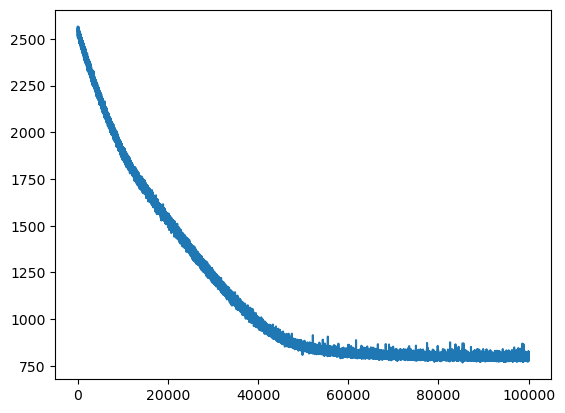

current_y_test.shape = (120,)
current_X_test.shape = (120, 110)
Step 1 took 1.12s
Step 7 took 1.05s
Step 13 took 1.08s
Step 19 took 1.06s
Step 25 took 1.07s
Step 31 took 1.06s
Step 37 took 1.06s
Step 43 took 1.06s
Step 49 took 1.73s
Step 55 took 1.12s
Step 61 took 1.07s
Step 67 took 1.06s
Step 73 took 1.10s
Step 79 took 1.10s
Step 85 took 1.12s
Step 91 took 1.14s
Step 97 took 1.10s
Step 103 took 1.09s
Step 109 took 1.15s
Step 115 took 1.73s


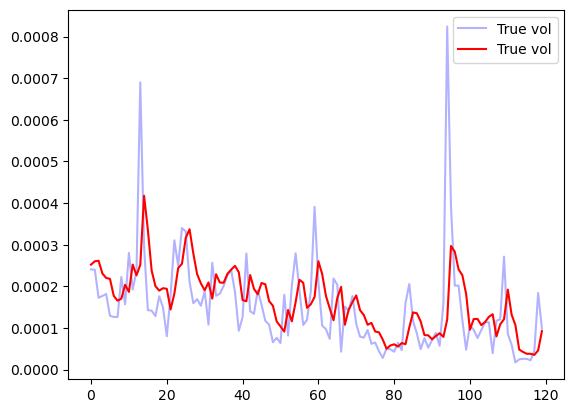

current_y_train.shape = (564,)
current_X_train.shape = (564, 110)


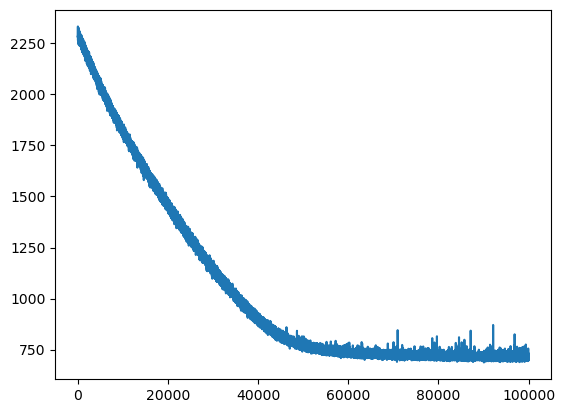

current_y_test.shape = (157,)
current_X_test.shape = (157, 110)
Step 1 took 1.06s
Step 8 took 1.01s
Step 15 took 1.01s
Step 22 took 1.04s
Step 29 took 1.06s
Step 36 took 1.04s
Step 43 took 1.06s
Step 50 took 1.03s
Step 57 took 1.04s
Step 64 took 1.06s
Step 71 took 1.74s
Step 78 took 1.08s
Step 85 took 1.06s
Step 92 took 1.05s
Step 99 took 1.09s
Step 106 took 1.06s
Step 113 took 1.08s
Step 120 took 1.07s
Step 127 took 1.07s
Step 134 took 1.07s
Step 141 took 1.09s
Step 148 took 1.10s
Step 155 took 1.08s


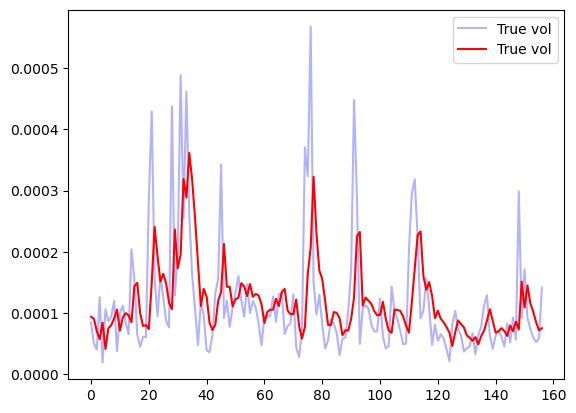

current_y_train.shape = (553,)
current_X_train.shape = (553, 110)


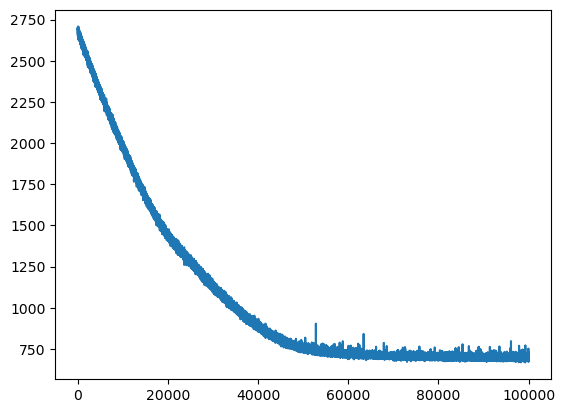

current_y_test.shape = (158,)
current_X_test.shape = (158, 110)
Step 1 took 1.06s
Step 8 took 1.00s
Step 15 took 1.02s
Step 22 took 1.05s
Step 29 took 1.00s
Step 36 took 1.02s
Step 43 took 1.02s
Step 50 took 1.02s
Step 57 took 1.07s
Step 64 took 1.03s
Step 71 took 1.08s
Step 78 took 1.80s
Step 85 took 1.05s
Step 92 took 1.05s
Step 99 took 1.05s
Step 106 took 1.06s
Step 113 took 1.06s
Step 120 took 1.06s
Step 127 took 1.06s
Step 134 took 1.07s
Step 141 took 1.43s
Step 148 took 1.08s
Step 155 took 1.08s


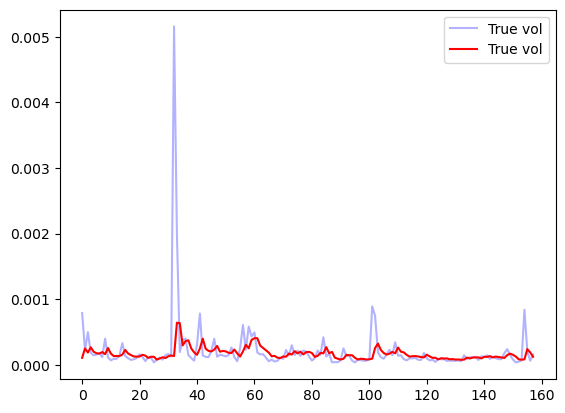

current_y_train.shape = (543,)
current_X_train.shape = (543, 110)


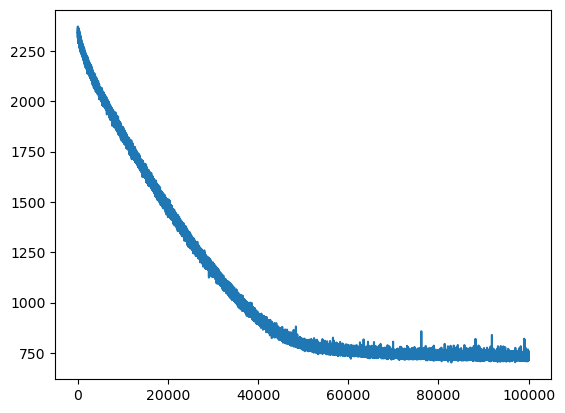

current_y_test.shape = (167,)
current_X_test.shape = (167, 110)
Step 1 took 1.05s
Step 9 took 0.99s
Step 17 took 1.00s
Step 25 took 0.99s
Step 33 took 1.01s
Step 41 took 1.70s
Step 49 took 1.01s
Step 57 took 1.01s
Step 65 took 1.05s
Step 73 took 1.04s
Step 81 took 1.05s
Step 89 took 1.03s
Step 97 took 1.06s
Step 105 took 1.05s
Step 113 took 1.05s
Step 121 took 1.06s
Step 129 took 1.81s
Step 137 took 1.06s
Step 145 took 1.06s
Step 153 took 1.07s
Step 161 took 1.08s


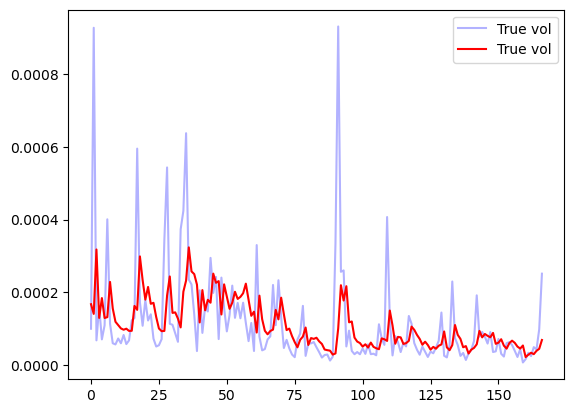

current_y_train.shape = (542,)
current_X_train.shape = (542, 110)


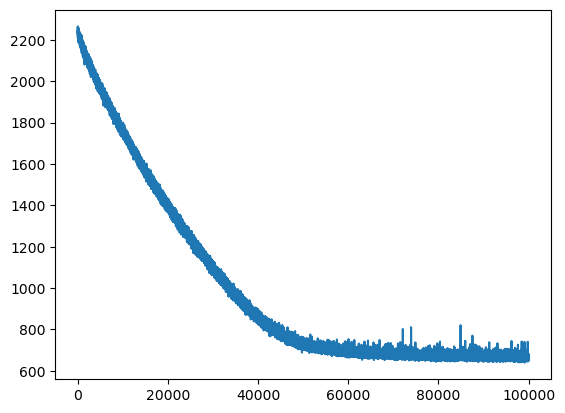

current_y_test.shape = (96,)
current_X_test.shape = (96, 110)
Step 1 took 1.04s
Step 5 took 1.00s
Step 9 took 1.01s
Step 13 took 1.00s
Step 17 took 1.73s
Step 21 took 1.00s
Step 25 took 1.01s
Step 29 took 1.00s
Step 33 took 1.05s
Step 37 took 1.00s
Step 41 took 1.04s
Step 45 took 1.01s
Step 49 took 1.01s
Step 53 took 1.03s
Step 57 took 1.02s
Step 61 took 1.02s
Step 65 took 1.02s
Step 69 took 1.02s
Step 73 took 1.04s
Step 77 took 1.02s
Step 81 took 1.06s
Step 85 took 1.04s
Step 89 took 1.04s
Step 93 took 1.04s


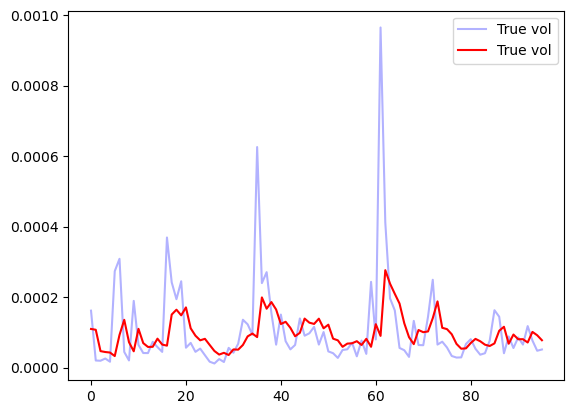

current_y_train.shape = (470,)
current_X_train.shape = (470, 110)


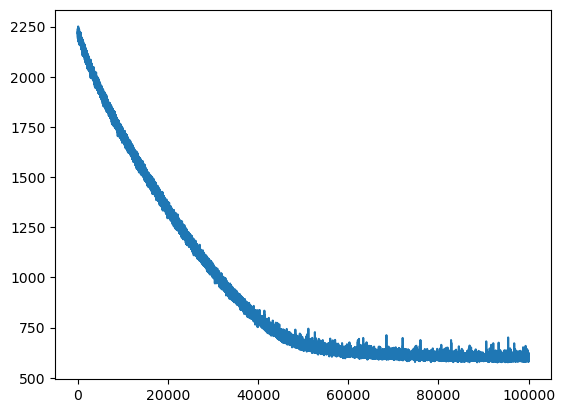

current_y_test.shape = (168,)
current_X_test.shape = (168, 110)
Step 1 took 1.86s
Step 9 took 0.97s
Step 17 took 0.99s
Step 25 took 1.70s
Step 33 took 0.97s
Step 41 took 0.97s
Step 49 took 0.99s
Step 57 took 1.02s
Step 65 took 1.00s
Step 73 took 1.01s
Step 81 took 1.01s
Step 89 took 1.00s
Step 97 took 1.00s
Step 105 took 1.03s
Step 113 took 1.02s
Step 121 took 1.04s
Step 129 took 1.02s
Step 137 took 1.02s
Step 145 took 1.08s
Step 153 took 1.03s
Step 161 took 1.11s


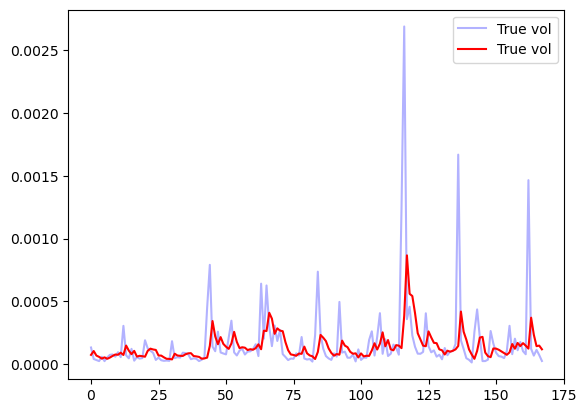

current_y_train.shape = (470,)
current_X_train.shape = (470, 110)


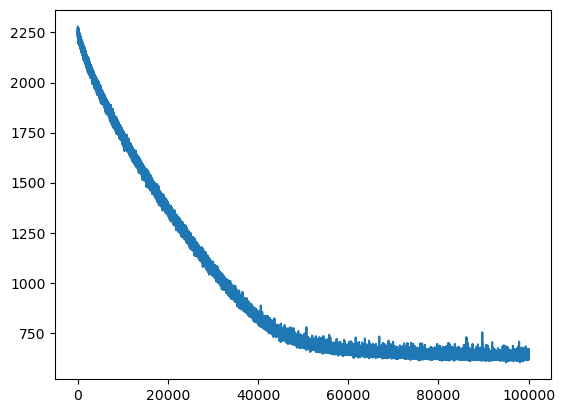

current_y_test.shape = (167,)
current_X_test.shape = (167, 110)
Step 1 took 1.00s
Step 9 took 0.95s
Step 17 took 0.96s
Step 25 took 1.04s
Step 33 took 1.16s
Step 41 took 1.00s
Step 49 took 0.97s
Step 57 took 1.01s
Step 65 took 1.12s
Step 73 took 1.00s
Step 81 took 1.00s
Step 89 took 1.00s
Step 97 took 1.01s
Step 105 took 1.01s
Step 113 took 1.03s
Step 121 took 1.01s
Step 129 took 1.05s
Step 137 took 1.02s
Step 145 took 1.71s
Step 153 took 1.03s
Step 161 took 1.04s


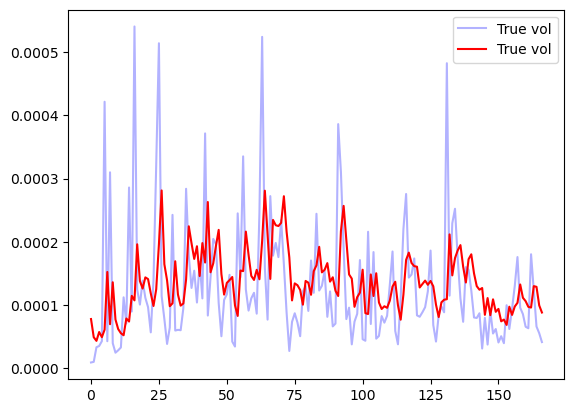

current_y_train.shape = (469,)
current_X_train.shape = (469, 110)


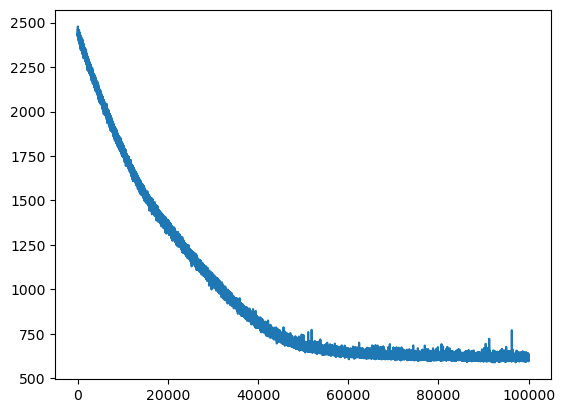

current_y_test.shape = (167,)
current_X_test.shape = (167, 110)
Step 1 took 1.07s
Step 9 took 0.95s
Step 17 took 0.96s
Step 25 took 0.95s
Step 33 took 0.97s
Step 41 took 0.98s
Step 49 took 0.97s
Step 57 took 0.97s
Step 65 took 0.99s
Step 73 took 0.99s
Step 81 took 1.32s
Step 89 took 1.00s
Step 97 took 1.07s
Step 105 took 1.01s
Step 113 took 1.02s
Step 121 took 1.02s
Step 129 took 1.02s
Step 137 took 1.01s
Step 145 took 1.02s
Step 153 took 1.02s
Step 161 took 1.05s


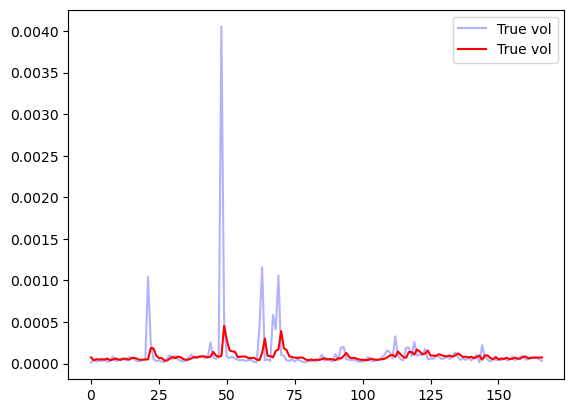

current_y_train.shape = (468,)
current_X_train.shape = (468, 110)


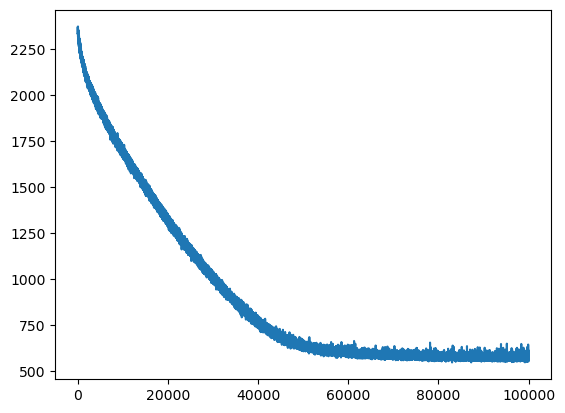

current_y_test.shape = (119,)
current_X_test.shape = (119, 110)
Step 1 took 1.01s
Step 6 took 0.94s
Step 11 took 0.95s
Step 16 took 0.95s
Step 21 took 0.95s
Step 26 took 0.95s
Step 31 took 0.95s
Step 36 took 0.96s
Step 41 took 0.96s
Step 46 took 0.97s
Step 51 took 0.96s
Step 56 took 0.97s
Step 61 took 0.98s
Step 66 took 0.98s
Step 71 took 0.97s
Step 76 took 0.98s
Step 81 took 1.03s
Step 86 took 0.99s
Step 91 took 0.99s
Step 96 took 1.00s
Step 101 took 0.99s
Step 106 took 1.00s
Step 111 took 1.05s
Step 116 took 1.00s


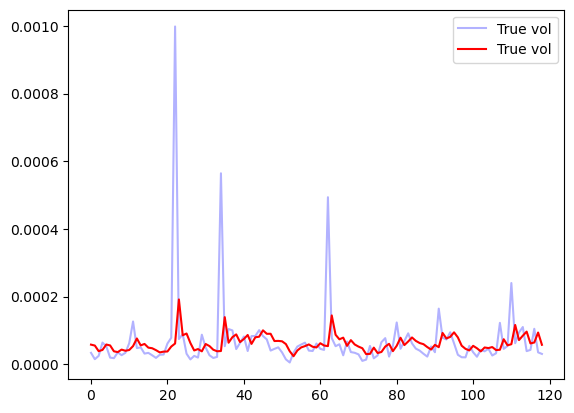

current_y_train.shape = (419,)
current_X_train.shape = (419, 110)


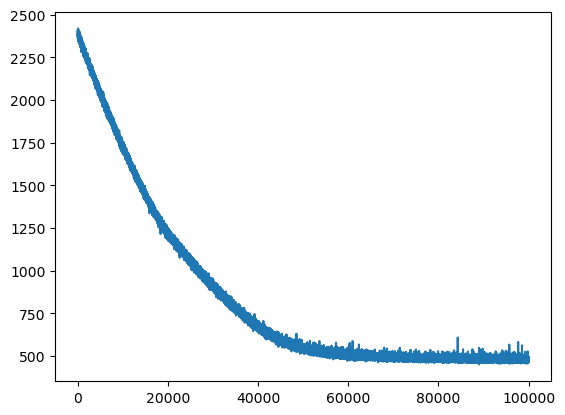

current_y_test.shape = (141,)
current_X_test.shape = (141, 110)
Step 1 took 0.99s
Step 8 took 0.92s
Step 15 took 0.94s
Step 22 took 0.93s
Step 29 took 0.93s
Step 36 took 0.93s
Step 43 took 0.97s
Step 50 took 1.01s
Step 57 took 0.95s
Step 64 took 0.97s
Step 71 took 0.95s
Step 78 took 0.96s
Step 85 took 0.96s
Step 92 took 0.97s
Step 99 took 0.97s
Step 106 took 0.97s
Step 113 took 0.98s
Step 120 took 0.98s
Step 127 took 1.04s
Step 134 took 0.99s
Step 141 took 0.99s


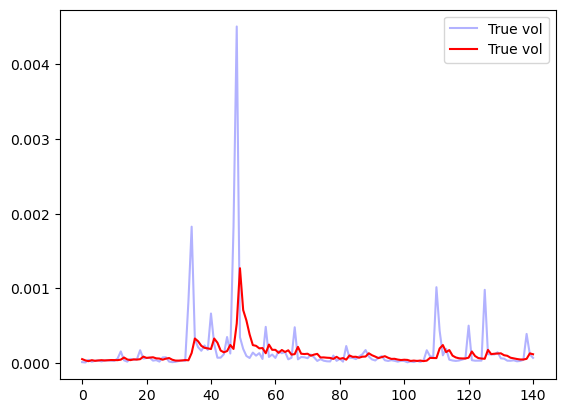

current_y_train.shape = (392,)
current_X_train.shape = (392, 110)


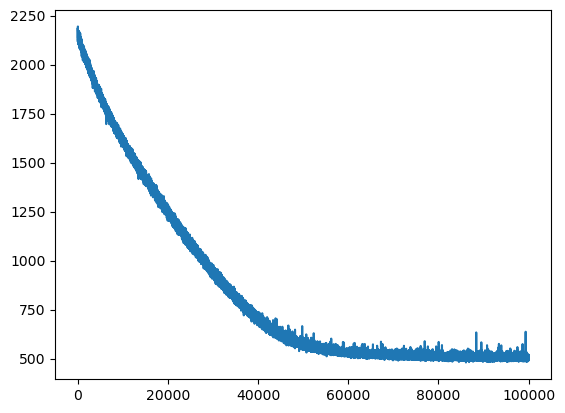

current_y_test.shape = (165,)
current_X_test.shape = (165, 110)
Step 1 took 1.03s
Step 9 took 0.91s
Step 17 took 0.93s
Step 25 took 0.92s
Step 33 took 1.22s
Step 41 took 0.99s
Step 49 took 0.95s
Step 57 took 1.05s
Step 65 took 0.96s
Step 73 took 0.95s
Step 81 took 1.03s
Step 89 took 1.05s
Step 97 took 1.04s
Step 105 took 1.92s
Step 113 took 0.99s
Step 121 took 1.05s
Step 129 took 1.08s
Step 137 took 1.08s
Step 145 took 1.07s
Step 153 took 1.05s
Step 161 took 1.10s


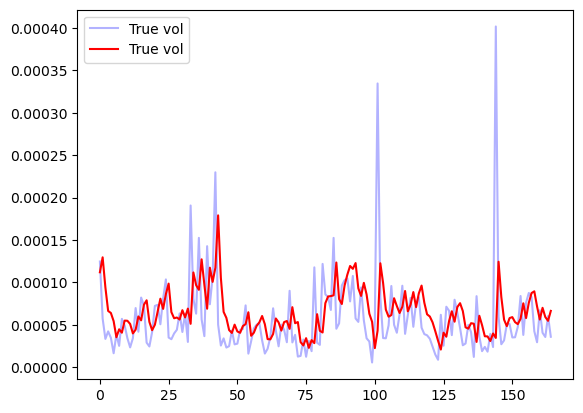

current_y_train.shape = (389,)
current_X_train.shape = (389, 110)


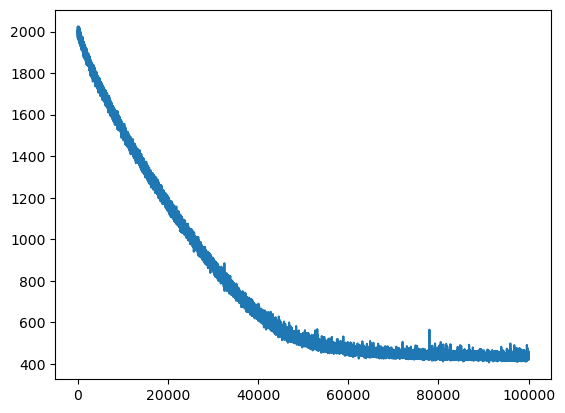

current_y_test.shape = (168,)
current_X_test.shape = (168, 110)
Step 1 took 1.10s
Step 9 took 0.96s
Step 17 took 0.96s
Step 25 took 0.93s
Step 33 took 0.93s
Step 41 took 0.93s
Step 49 took 0.93s
Step 57 took 1.70s
Step 65 took 1.04s
Step 73 took 1.07s
Step 81 took 1.12s
Step 89 took 1.32s
Step 97 took 1.14s
Step 105 took 1.69s
Step 113 took 1.40s
Step 121 took 1.15s
Step 129 took 1.12s
Step 137 took 1.11s
Step 145 took 1.23s
Step 153 took 1.84s
Step 161 took 1.11s


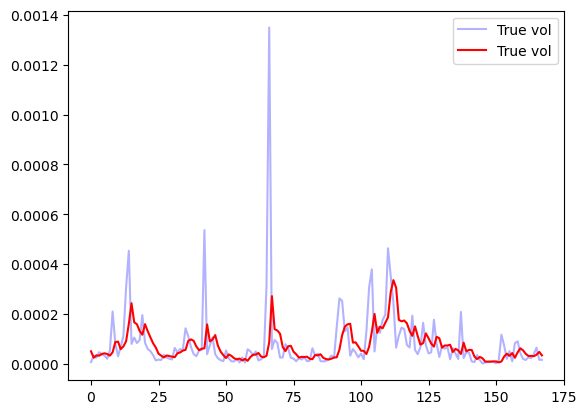

In [154]:
num_sets = len(training_sets)
preds = []
errors = []

for n in range(num_sets):
    current_training_set = training_sets[n]
    current_testing_set = test_sets[n]

    current_y_train = current_training_set[0]
    current_X_train = current_training_set[1]

    print(f"current_y_train.shape = {current_y_train.shape}")
    print(f"current_X_train.shape = {current_X_train.shape}")

    current_model = sts_model(y_train=current_y_train, X_train=current_X_train)

    ELBO_loss = current_model.train(int(1e5))

    plt.plot(ELBO_loss)
    plt.show()

    current_y_test = current_testing_set[0]
    current_X_test = current_testing_set[1]

    print(f"current_y_test.shape = {current_y_test.shape}")
    print(f"current_X_test.shape = {current_X_test.shape}")

    preds = current_model.interval_one_step_pred(
        y_test=current_y_test, X_test=current_X_test, print_=True
    )
    pred_means = []
    pred_stds = []
    for i in range(len(preds)):
        pred_means.append(preds[i]["y_pred_mean"])
        pred_stds.append(preds[i]["y_pred_std"])

    vol_pred_mean = np.exp(
        pred_means + 0.5 * (np.power(pred_stds, 2 * np.ones_like(pred_stds)))
    )
    vol_true = np.exp(current_y_test)
    rmse_n = root_mean_squared_error(vol_true, vol_pred_mean)
    mae_n = mean_absolute_error(vol_true, vol_pred_mean)
    errors_n = {f"RMSE {n}": rmse_n, f"MAE {n}": mae_n}
    errors.append(errors_n)

    plt.plot(vol_true, alpha=0.3, color="b", label="True vol")
    plt.plot(vol_pred_mean, color="r", label="True vol")
    plt.legend()
    plt.show()

In [69]:
num_errors = len(errors)

for i in range(num_errors):
    print(errors[i])

{'RMSE 0': 0.0001069191586378605, 'MAE 0': 6.790617931092838e-05}
{'RMSE 1': 9.182132731901079e-05, 'MAE 1': 6.0417819583827686e-05}
{'RMSE 2': 0.00044551812731952363, 'MAE 2': 0.00013701170336641655}
{'RMSE 3': 0.00013515684263582068, 'MAE 3': 7.415311266249292e-05}
{'RMSE 4': 0.00012854018337977627, 'MAE 4': 6.836579290416472e-05}
{'RMSE 5': 0.0003006392085398052, 'MAE 5': 0.00014344150081922023}
{'RMSE 6': 0.0001015221864200324, 'MAE 6': 7.260199303458874e-05}
{'RMSE 7': 0.0003433813285626251, 'MAE 7': 8.993887112656532e-05}
{'RMSE 8': 0.00011377631251264361, 'MAE 8': 4.5434324036717305e-05}
{'RMSE 9': 0.0004390259324907775, 'MAE 9': 0.0001476379291790428}
{'RMSE 10': 5.301362796347996e-05, 'MAE 10': 3.282755265951762e-05}
{'RMSE 11': 0.00012967974143251006, 'MAE 11': 5.857244997958959e-05}


In [55]:
df_past_vol = lagged_df.iloc[:, : vol_look_back + 2]

training_sets_past_vols, test_sets_past_vols = make_weekly_walk_forward_splits(
    df=df_past_vol,
    date_col="datetime",
    initial_training_set_end=train_end_data,
    target_col="log(vol)",
)

In [59]:
test_sets_past_vols[0][1].shape

(120, 10)

current_y_train.shape = (612,)
current_X_train.shape = (612, 10)


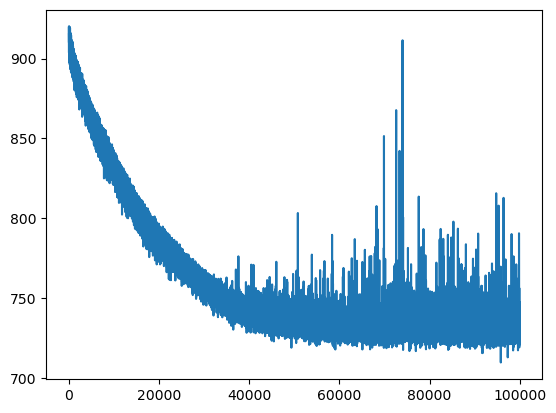

current_y_test.shape = (120,)
current_X_test.shape = (120, 10)
Step 1 took 1.08s
Step 7 took 1.50s
Step 13 took 1.02s
Step 19 took 1.03s
Step 25 took 1.03s
Step 31 took 1.04s
Step 37 took 1.34s
Step 43 took 1.06s
Step 49 took 1.04s
Step 55 took 1.05s
Step 61 took 1.06s
Step 67 took 1.06s
Step 73 took 1.06s
Step 79 took 1.43s
Step 85 took 1.07s
Step 91 took 1.06s
Step 97 took 1.08s
Step 103 took 1.07s
Step 109 took 1.09s
Step 115 took 1.08s


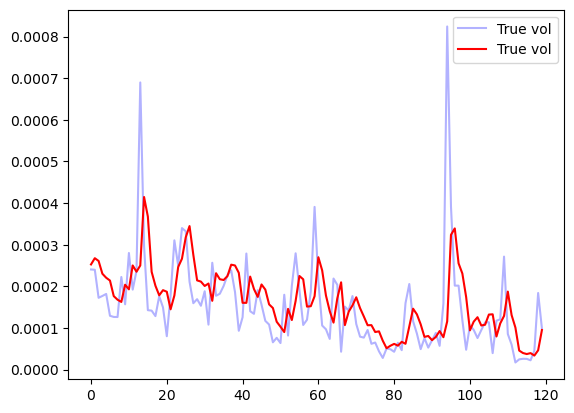

current_y_train.shape = (564,)
current_X_train.shape = (564, 10)


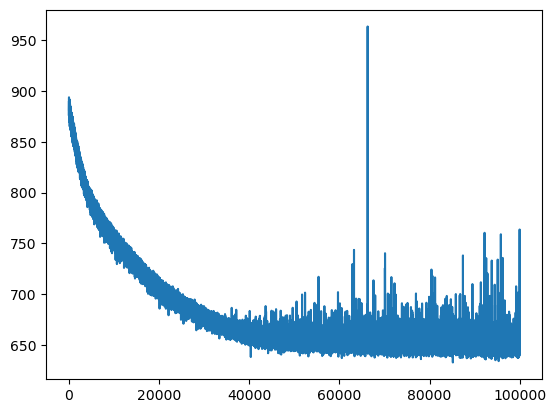

current_y_test.shape = (157,)
current_X_test.shape = (157, 10)
Step 1 took 1.18s
Step 8 took 1.03s
Step 15 took 1.01s
Step 22 took 1.04s
Step 29 took 1.08s
Step 36 took 1.12s
Step 43 took 1.02s
Step 50 took 1.42s
Step 57 took 1.04s
Step 64 took 1.05s
Step 71 took 1.05s
Step 78 took 1.09s
Step 85 took 1.04s
Step 92 took 1.10s
Step 99 took 1.10s
Step 106 took 1.05s
Step 113 took 1.07s
Step 120 took 1.08s
Step 127 took 1.09s
Step 134 took 1.08s
Step 141 took 1.10s
Step 148 took 1.09s
Step 155 took 1.65s


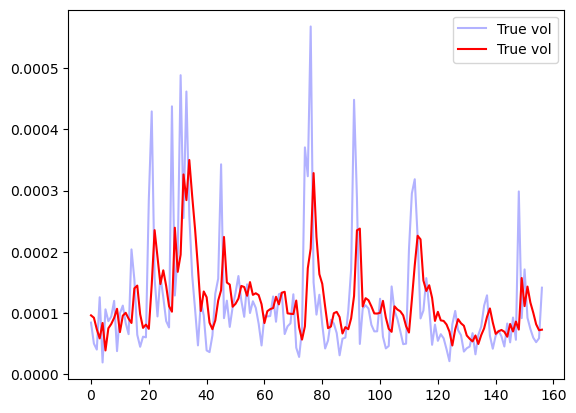

current_y_train.shape = (553,)
current_X_train.shape = (553, 10)


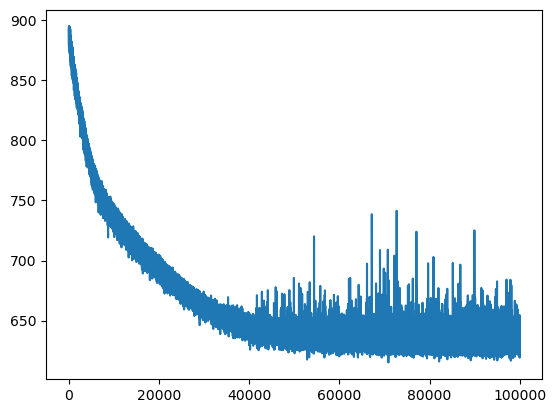

current_y_test.shape = (158,)
current_X_test.shape = (158, 10)
Step 1 took 1.60s
Step 8 took 1.06s
Step 15 took 1.01s
Step 22 took 1.08s
Step 29 took 1.10s
Step 36 took 1.06s
Step 43 took 1.12s
Step 50 took 1.06s
Step 57 took 1.06s
Step 64 took 1.21s
Step 71 took 1.13s
Step 78 took 1.08s
Step 85 took 1.07s
Step 92 took 1.48s
Step 99 took 1.05s
Step 106 took 1.22s
Step 113 took 1.07s
Step 120 took 1.05s
Step 127 took 1.12s
Step 134 took 1.12s
Step 141 took 1.10s
Step 148 took 1.07s
Step 155 took 1.08s


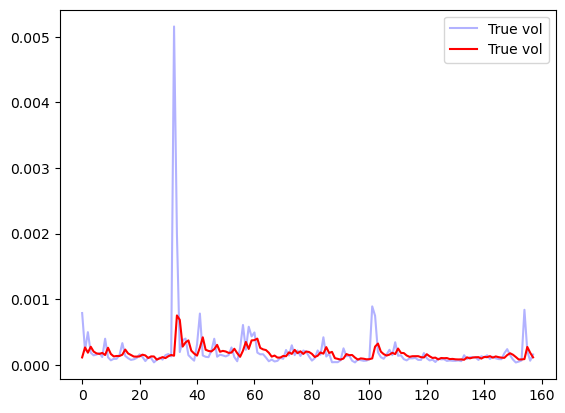

current_y_train.shape = (543,)
current_X_train.shape = (543, 10)


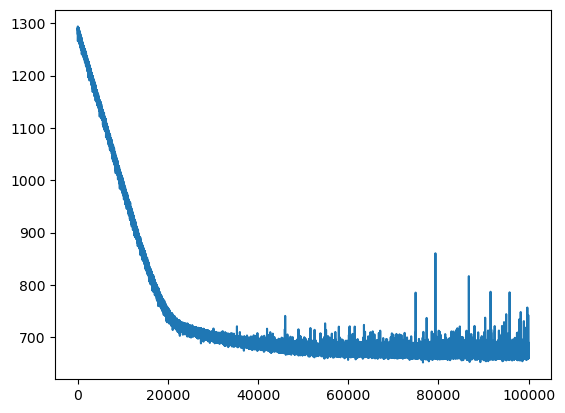

current_y_test.shape = (167,)
current_X_test.shape = (167, 10)
Step 1 took 1.18s
Step 9 took 0.99s
Step 17 took 0.99s
Step 25 took 1.01s
Step 33 took 0.99s
Step 41 took 1.05s
Step 49 took 1.02s
Step 57 took 1.12s
Step 65 took 1.02s
Step 73 took 1.03s
Step 81 took 1.09s
Step 89 took 1.03s
Step 97 took 1.25s
Step 105 took 1.08s
Step 113 took 1.12s
Step 121 took 1.49s
Step 129 took 1.05s
Step 137 took 1.12s
Step 145 took 1.13s
Step 153 took 1.06s
Step 161 took 1.09s


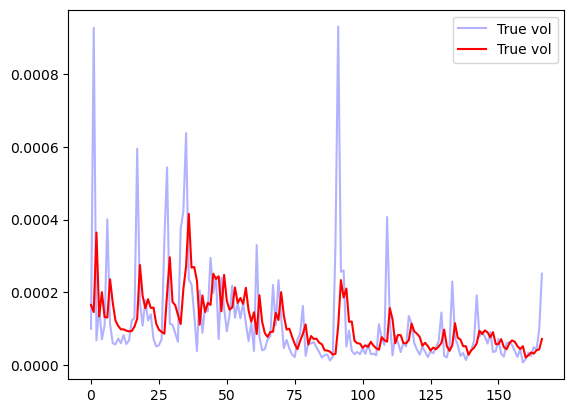

current_y_train.shape = (542,)
current_X_train.shape = (542, 10)


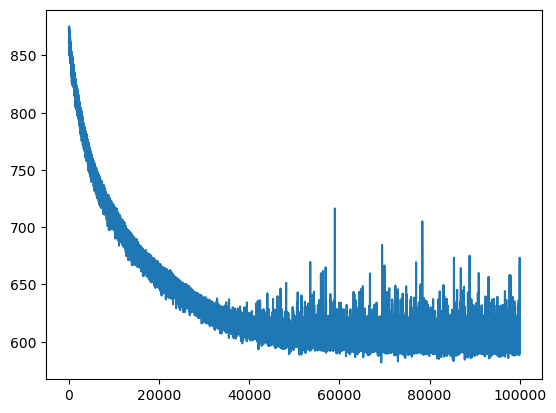

current_y_test.shape = (96,)
current_X_test.shape = (96, 10)
Step 1 took 1.07s
Step 5 took 0.99s
Step 9 took 1.04s
Step 13 took 1.00s
Step 17 took 1.02s
Step 21 took 0.99s
Step 25 took 0.99s
Step 29 took 1.00s
Step 33 took 1.00s
Step 37 took 1.01s
Step 41 took 1.02s
Step 45 took 1.01s
Step 49 took 1.01s
Step 53 took 1.01s
Step 57 took 1.01s
Step 61 took 1.04s
Step 65 took 1.02s
Step 69 took 1.03s
Step 73 took 1.02s
Step 77 took 1.03s
Step 81 took 1.03s
Step 85 took 1.02s
Step 89 took 1.05s
Step 93 took 1.03s


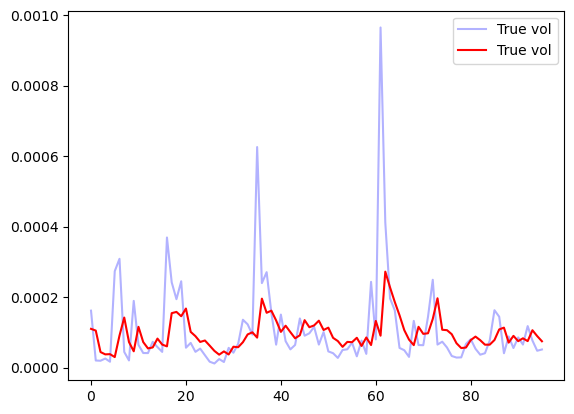

current_y_train.shape = (470,)
current_X_train.shape = (470, 10)


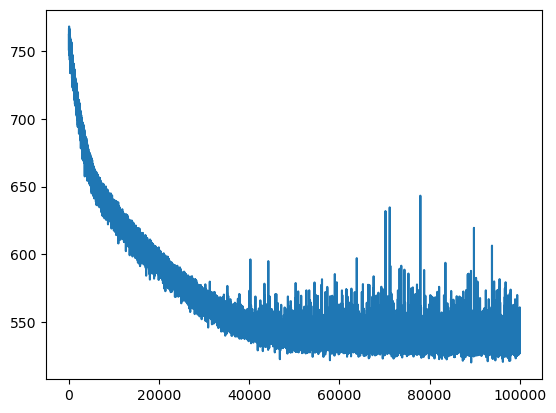

current_y_test.shape = (168,)
current_X_test.shape = (168, 10)
Step 1 took 1.00s
Step 9 took 0.98s
Step 17 took 0.96s
Step 25 took 0.95s
Step 33 took 0.96s
Step 41 took 0.96s
Step 49 took 0.97s
Step 57 took 0.97s
Step 65 took 0.97s
Step 73 took 0.98s
Step 81 took 0.98s
Step 89 took 1.00s
Step 97 took 0.99s
Step 105 took 1.04s
Step 113 took 1.01s
Step 121 took 1.02s
Step 129 took 1.02s
Step 137 took 1.02s
Step 145 took 1.02s
Step 153 took 1.03s
Step 161 took 1.04s


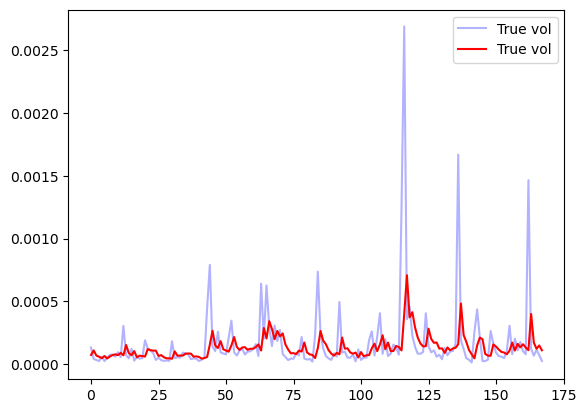

current_y_train.shape = (470,)
current_X_train.shape = (470, 10)


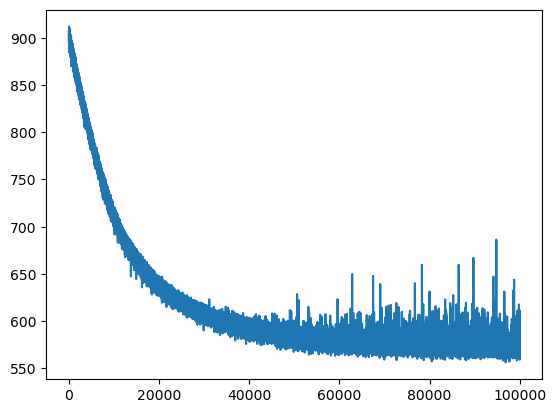

current_y_test.shape = (167,)
current_X_test.shape = (167, 10)
Step 1 took 1.00s
Step 9 took 0.98s
Step 17 took 0.95s
Step 25 took 0.98s
Step 33 took 1.00s
Step 41 took 1.00s
Step 49 took 0.97s
Step 57 took 0.98s
Step 65 took 1.00s
Step 73 took 0.99s
Step 81 took 1.01s
Step 89 took 0.99s
Step 97 took 1.07s
Step 105 took 1.22s
Step 113 took 1.02s
Step 121 took 1.02s
Step 129 took 1.02s
Step 137 took 1.13s
Step 145 took 1.03s
Step 153 took 1.07s
Step 161 took 1.03s


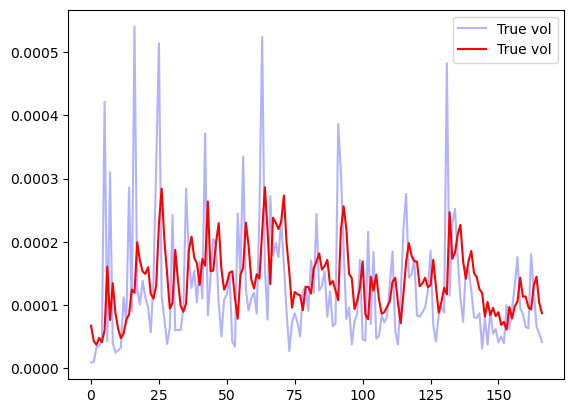

current_y_train.shape = (469,)
current_X_train.shape = (469, 10)


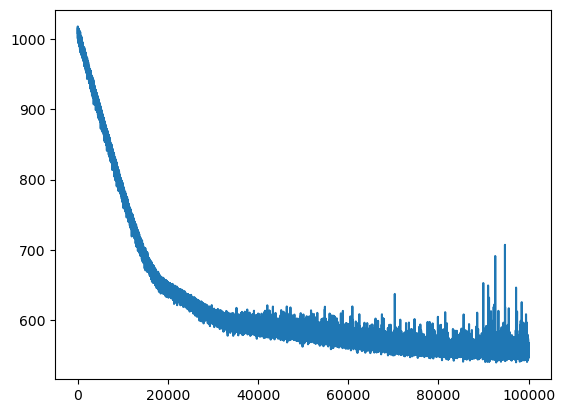

current_y_test.shape = (167,)
current_X_test.shape = (167, 10)
Step 1 took 0.99s
Step 9 took 0.95s
Step 17 took 0.96s
Step 25 took 0.96s
Step 33 took 0.97s
Step 41 took 0.96s
Step 49 took 0.96s
Step 57 took 0.98s
Step 65 took 0.98s
Step 73 took 0.98s
Step 81 took 0.98s
Step 89 took 0.99s
Step 97 took 0.99s
Step 105 took 0.99s
Step 113 took 1.00s
Step 121 took 1.04s
Step 129 took 1.01s
Step 137 took 1.01s
Step 145 took 1.02s
Step 153 took 1.03s
Step 161 took 1.03s


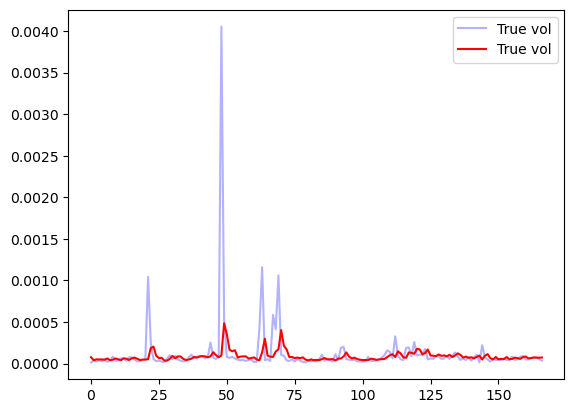

current_y_train.shape = (468,)
current_X_train.shape = (468, 10)


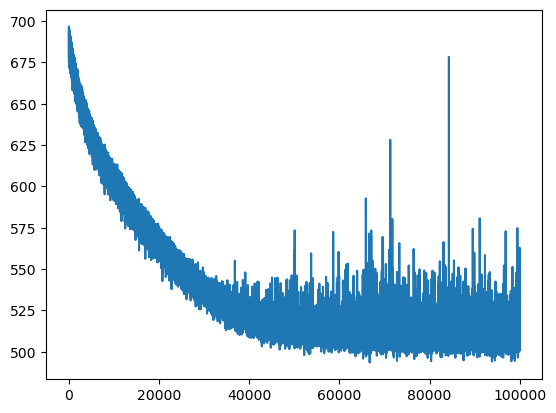

current_y_test.shape = (119,)
current_X_test.shape = (119, 10)
Step 1 took 0.99s
Step 6 took 1.48s
Step 11 took 0.95s
Step 16 took 0.96s
Step 21 took 0.96s
Step 26 took 0.96s
Step 31 took 0.99s
Step 36 took 0.97s
Step 41 took 1.20s
Step 46 took 0.97s
Step 51 took 0.97s
Step 56 took 0.97s
Step 61 took 0.99s
Step 66 took 0.98s
Step 71 took 0.98s
Step 76 took 0.98s
Step 81 took 0.99s
Step 86 took 0.99s
Step 91 took 0.99s
Step 96 took 0.99s
Step 101 took 0.99s
Step 106 took 0.99s
Step 111 took 1.02s
Step 116 took 1.00s


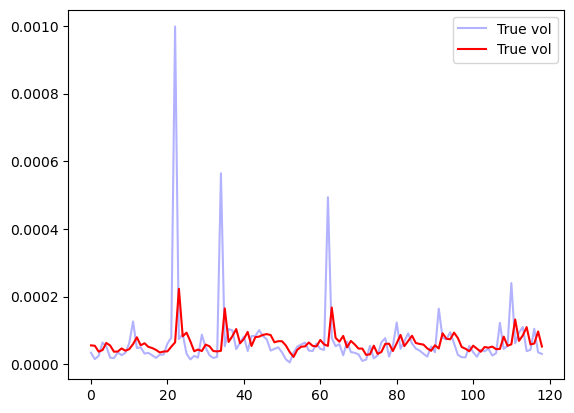

current_y_train.shape = (419,)
current_X_train.shape = (419, 10)


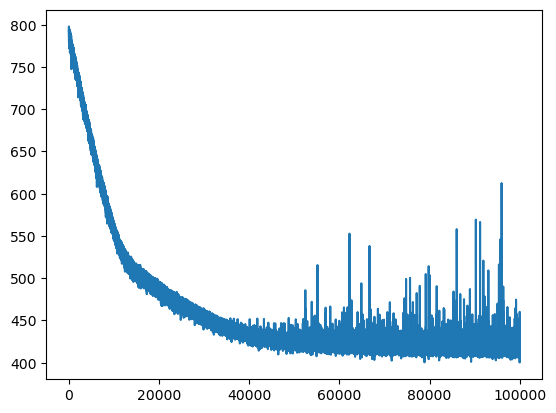

current_y_test.shape = (141,)
current_X_test.shape = (141, 10)
Step 1 took 0.95s
Step 8 took 0.96s
Step 15 took 0.94s
Step 22 took 0.92s
Step 29 took 0.92s
Step 36 took 0.93s
Step 43 took 0.94s
Step 50 took 0.94s
Step 57 took 0.94s
Step 64 took 0.96s
Step 71 took 0.96s
Step 78 took 1.56s
Step 85 took 0.96s
Step 92 took 0.98s
Step 99 took 0.97s
Step 106 took 0.98s
Step 113 took 0.99s
Step 120 took 0.97s
Step 127 took 0.98s
Step 134 took 0.99s
Step 141 took 0.99s


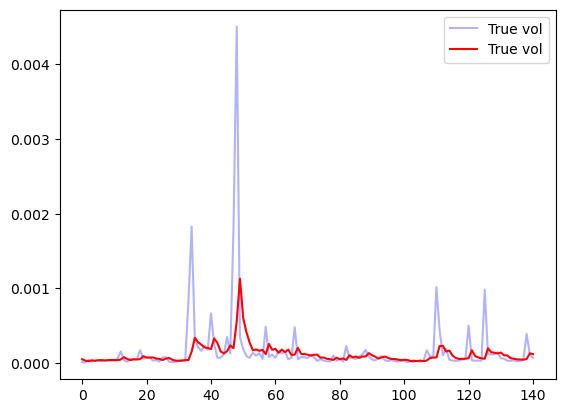

current_y_train.shape = (392,)
current_X_train.shape = (392, 10)


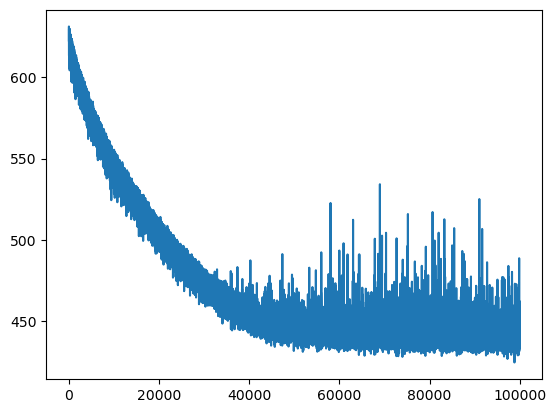

current_y_test.shape = (165,)
current_X_test.shape = (165, 10)
Step 1 took 0.97s
Step 9 took 0.90s
Step 17 took 0.91s
Step 25 took 0.91s
Step 33 took 0.91s
Step 41 took 1.18s
Step 49 took 0.93s
Step 57 took 0.92s
Step 65 took 0.93s
Step 73 took 0.94s
Step 81 took 0.97s
Step 89 took 0.95s
Step 97 took 0.95s
Step 105 took 1.00s
Step 113 took 0.96s
Step 121 took 0.97s
Step 129 took 0.98s
Step 137 took 0.97s
Step 145 took 0.97s
Step 153 took 0.98s
Step 161 took 0.99s


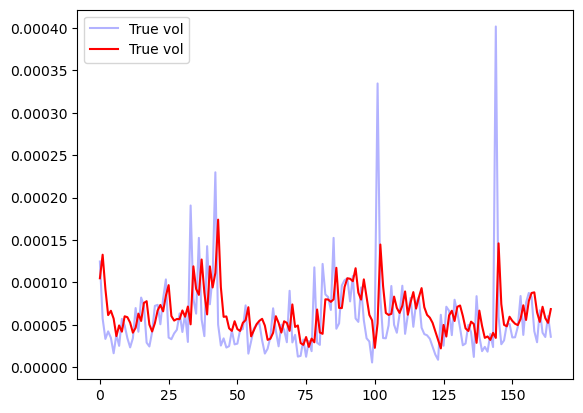

current_y_train.shape = (389,)
current_X_train.shape = (389, 10)


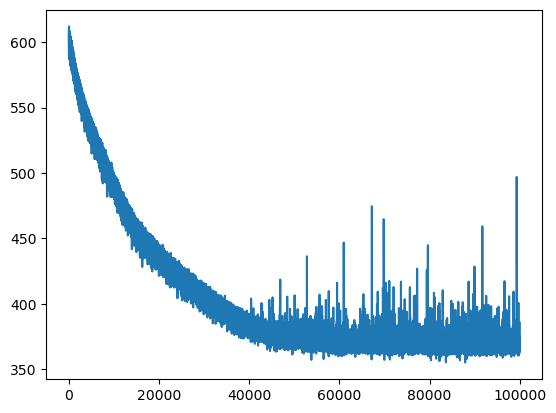

current_y_test.shape = (168,)
current_X_test.shape = (168, 10)
Step 1 took 0.96s
Step 9 took 0.92s
Step 17 took 0.91s
Step 25 took 0.91s
Step 33 took 0.91s
Step 41 took 0.95s
Step 49 took 0.93s
Step 57 took 0.93s
Step 65 took 1.34s
Step 73 took 0.94s
Step 81 took 0.94s
Step 89 took 0.95s
Step 97 took 0.95s
Step 105 took 0.95s
Step 113 took 0.96s
Step 121 took 0.96s
Step 129 took 0.96s
Step 137 took 0.97s
Step 145 took 0.98s
Step 153 took 1.45s
Step 161 took 0.98s


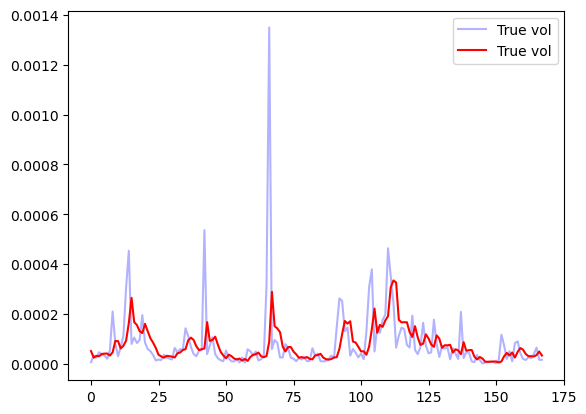

In [61]:
num_sets = len(training_sets_past_vols)
preds_past_vols = []
errors_past_vols = []

for n in range(num_sets):
    current_training_set = training_sets_past_vols[n]
    current_testing_set = test_sets_past_vols[n]

    current_y_train = current_training_set[0]
    current_X_train = current_training_set[1]

    print(f"current_y_train.shape = {current_y_train.shape}")
    print(f"current_X_train.shape = {current_X_train.shape}")

    current_model = sts_model(y_train=current_y_train, X_train=current_X_train)

    ELBO_loss = current_model.train(int(1e5))

    plt.plot(ELBO_loss)
    plt.show()

    current_y_test = current_testing_set[0]
    current_X_test = current_testing_set[1]

    print(f"current_y_test.shape = {current_y_test.shape}")
    print(f"current_X_test.shape = {current_X_test.shape}")

    preds = current_model.interval_one_step_pred(
        y_test=current_y_test, X_test=current_X_test, print_=True
    )
    pred_means = []
    pred_stds = []
    for i in range(len(preds)):
        pred_means.append(preds[i]["y_pred_mean"])
        pred_stds.append(preds[i]["y_pred_std"])

    vol_pred_mean = np.exp(
        pred_means + 0.5 * (np.power(pred_stds, 2 * np.ones_like(pred_stds)))
    )
    vol_true = np.exp(current_y_test)
    rmse_n = root_mean_squared_error(vol_true, vol_pred_mean)
    mae_n = mean_absolute_error(vol_true, vol_pred_mean)
    errors_n = {f"RMSE {n}": rmse_n, f"MAE {n}": mae_n}
    errors_past_vols.append(errors_n)

    plt.plot(vol_true, alpha=0.3, color="b", label="True vol")
    plt.plot(vol_pred_mean, color="r", label="True vol")
    plt.legend()
    plt.show()

In [63]:
num_errors_past_vols = len(errors_past_vols)

for i in range(num_errors_past_vols):
    print(errors_past_vols[i])

{'RMSE 0': 0.00010547733260821248, 'MAE 0': 6.666659625005554e-05}
{'RMSE 1': 9.041996954790105e-05, 'MAE 1': 5.922871451701792e-05}
{'RMSE 2': 0.0004396979543529896, 'MAE 2': 0.0001312379995063094}
{'RMSE 3': 0.00013425944295393386, 'MAE 3': 7.338587035691665e-05}
{'RMSE 4': 0.00012708051989049053, 'MAE 4': 6.529898481377809e-05}
{'RMSE 5': 0.00028603103200198083, 'MAE 5': 0.00012319341251182666}
{'RMSE 6': 0.00010087217023360867, 'MAE 6': 7.215875633643932e-05}
{'RMSE 7': 0.00034266913698197127, 'MAE 7': 8.963212237522306e-05}
{'RMSE 8': 0.00011329033928779681, 'MAE 8': 4.441190014360311e-05}
{'RMSE 9': 0.0004257339678237332, 'MAE 9': 0.00013647215604777705}
{'RMSE 10': 5.151287145046429e-05, 'MAE 10': 3.1719732120387066e-05}
{'RMSE 11': 0.00012908164648329075, 'MAE 11': 5.790434763409531e-05}


In [65]:
num_errors = len(errors)

for i in range(num_errors):
    print(errors[i])

{'RMSE 0': 0.00010581071086230296, 'MAE 0': 6.707548471562506e-05}
{'RMSE 1': 9.225523969813999e-05, 'MAE 1': 6.0829229899874674e-05}
{'RMSE 2': 0.00044371718819594363, 'MAE 2': 0.00013250035884595387}
{'RMSE 3': 0.0001334936619876965, 'MAE 3': 7.317934395312908e-05}
{'RMSE 4': 0.0001278490024945742, 'MAE 4': 6.743313492605774e-05}
{'RMSE 5': 0.00029081095594943004, 'MAE 5': 0.00012963616793551795}
{'RMSE 6': 0.00010029709052791454, 'MAE 6': 7.100643112672364e-05}
{'RMSE 7': 0.0003426404576957222, 'MAE 7': 8.81888709538253e-05}
{'RMSE 8': 0.00011285038486019901, 'MAE 8': 4.376871194469771e-05}
{'RMSE 9': 0.00043234227937924153, 'MAE 9': 0.00014143561945332894}
{'RMSE 10': 5.164848020601999e-05, 'MAE 10': 3.1927487743943786e-05}
{'RMSE 11': 0.00012912366137396623, 'MAE 11': 5.8021918582627686e-05}
